# Optimal Sample Sizes and Refined Machine Learning Techniques

The dataset used for these analyses has been re-sampled to include only regions in which at least one receiver is deployed. This will help to come up with results that are more true to real conditions. Previous machine learning techniques were using a dataset that also had data for times in which no receivers were in the water, which was giving us a model precision score that was too good to be true (if no receivers are in the water looking for sharks, there are automatically no sharks in the water). This is not logically true, but is true from a data standpoint. By removing the times when there are no receivers in the water, we get more realistic precision values and a better idea of other parameters (apart from just receiver presence or absence) that may lead to shark presence in a particular area.

### General Housekeeping

In [1]:
# Import Libraries
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import metrics 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

# Decision Trees
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree 

# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

# K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

# Grid Search
from sklearn.model_selection import GridSearchCV

In [2]:
# Build an easy function to get precision and recall
# from the confusion matrix
def precision_recall_calc(true, predicted):
    """"""" Calculates precision and recall scores for a particular model """""""
    cm = confusion_matrix(true, predicted)
    p = cm[0,0]/(cm[0,0] + cm[1,0])
    r = cm[0,0]/(cm[0,0] + cm[0,1])
    return p, r

### Data Acquisition and Cleaning

In [3]:
# Read in the dataset and do some quick data cleanup.
dat = pd.read_csv('D:/Documents/SpringBoard/capstone-1/datasets/final_files/combined/'
                  'filled/jackknifed_counts_new.csv', 
                 parse_dates=['Date']) 

dat['Receiver_D'] = dat['Receiver_D'].astype('category') # turn receiver D into a category
    # for analyses and plotting
dat['Year'] = dat['Year'].astype('category') # turn into a category
dat['Transmitter'] = pd.to_numeric(dat['Transmitter'], errors='coerce') # and make
    # sure that the 'Transmitter' (shark density) is numeric
    
dat['Receiver_D'] = dat['Receiver_D'].cat.remove_unused_categories()

In [4]:
# Add presence v absence column
dat['presence'] = dat['Transmitter'].copy() # make a copy of the transmitter data
dat['presence'].values[dat['presence'].values > 1] = 1 # and convert transmitter vals > 1
    # to 1
dat['presence'] = dat['presence'].astype('category') # convert to category so
    # that we can run some t-tests
    
orig_dat = dat.copy() # to save in case we decide that we don't need to do dummies
    # to run a model (like is described in Decision Trees)

In [5]:
# Balance the data - make sure there are an even number of 0s and 1s
# We're going to upsample so that we don't lose any data where sharks 
# aren't there (and because we don't really have enough data to 'spare')
zeros = dat[dat.presence == 0] # data without sharks
ones = dat[dat.presence == 1].sample(len(zeros), random_state=33, replace=True)
    # take a random sample of 1s

dat = ones.append(zeros) # re-write data frame

In [6]:
# Separate the data into predictors and response variables
dat = dat[['presence','Zone','Receiver_D', 'DepthGradient', 'TempC', 
           'Sal', 'ChlA', 'MoonPhase', 'Month', 'Year']].copy()
dat = dat.astype({'Zone':'object', 'Receiver_D':'object',
                  'MoonPhase':'object', 'Month':'object', 'Year':'object'})

In [7]:
# Get dummy variables for the model and drop the first value so that
# data are not redundant
categories = pd.get_dummies(dat.loc[:,['Zone', 'MoonPhase', 'Month', 
                                       'Year', 'Receiver_D']], drop_first=True)

In [8]:
# Copy the dummy columns back into the dataset
dat[categories.columns] = categories.copy()

In [9]:
# Drop the original columns that we have dummies set up for
dat = dat.drop(['Zone', 'MoonPhase', 'Receiver_D','Month', 'Year'], axis=1) 

### Optimal Sample Size

How many samples should we have if we want to get a good model output? Figuring out this ideal number could help to reduce sample size and training time, which is ideal for scenarios when we need a quick turn-around and when watching a computer code run isn't ini our best interest. This will be demonstratied using the DecisionTreeClassifier, because this classifier is ideal for the kind of question that we want to answer with these data: Which factors (and which range of values within the factors) drives shark presence or shark absence?

In [10]:
# Let's start with a sequential grab of data values that increase
# exponentially
grab_samples = [2**i for i in range(8,14)] # grab samples

# Begin the iterations
sample_size = pd.DataFrame() # build an empty dataframe to add to

for row, value in enumerate(range(100)): # for 100 iterations
    for sample in grab_samples: # for each grab in grab_samples
        # Step 1: Generate the data
        dat_sample = dat.sample(sample, random_state=row) # randomly jacknife
            # the dataset; change random state throughout iterations but still
            # specify one for reproducibility
        y = dat_sample.presence # save the response variable
        X = dat_sample.drop('presence', axis=1) # save the predictors

        # Step 2: Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                            random_state=33) 
            # Let's do a train/test split here
            
        # Step 3: Run the Model
        gs = DecisionTreeClassifier(max_depth=5, random_state=33)
            # Let's specify a max_depth value of 5 for this example. This will
            # give us a decision tree that is relatively easy to follow and
            # might give us decent modeling results
        
        gs.fit(X_train, y_train) # fit model to the training data
    
        # Step 4: Analyze results
        y_pred_train = gs.predict(X_train) # predict the training and...
        y_pred_test = gs.predict(X_test) # the testing datasets
    
        train_score = cross_val_score(gs, X_train, y_train, cv=3, 
                                     scoring='precision') # and us
            # cross validation to come up with scores for each fold (fold = 3)
            # because our original grab sample is quite small and we need at least
            # 5 values in each response category to get a good model
        test_score = cross_val_score(gs, X_test, y_test, cv=3, 
                                    scoring='precision') 
            # do the same for the test scores
    
        new_row = pd.DataFrame({'sample': sample, 'train_score':train_score,
                                'test_score':test_score})
            # save the data to a new row
    
        sample_size = sample_size.append(new_row, ignore_index=True)
            # and append the data to the running list

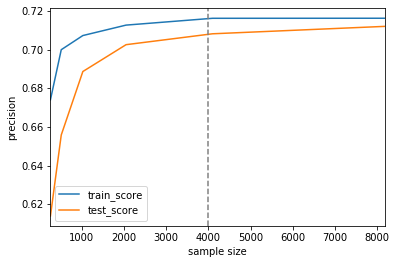

        train_score  test_score
sample                         
256        0.674153    0.613991
512        0.700035    0.655884
1024       0.707362    0.688739
2048       0.712765    0.702635
4096       0.716291    0.708271
8192       0.716319    0.712122


In [11]:
# Plot the results
sample_size = sample_size.groupby(['sample']).agg('mean') # get the mean scores
    # at each sample value (lots of iterations)
sample_size.plot(y=['train_score', 'test_score']) # plot
plt.axvline(x=4000, color='gray', linestyle='dashed') # add line where
    # it looks like it starts to even out
plt.ylabel('precision')
plt.xlabel('sample size')
plt.show() # show plot

print(sample_size) # print results

Here, it looks like a value around 4000 is ideal because both the train and test scores are beginning to plateau. These values plateau at a precision of 70%. This isn't terrible, but it's also not very good. I just chose a max_depth of 5 for this example so that processing time was quick. We would expect a similar number of data points to reach convergence at other max depth options. 

### Plotting the Best Model Parameters using GridSearch

In [12]:
# Split data appropriately
y = dat.presence
X = dat.drop('presence', axis=1)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33) 

##### Begin by using the Tree Classifier

In [13]:
# Grid Search for tree classifier
parameters = {'max_depth':[3,4,5,6,7,8,9,10]}
    # Set parameters
gs = DecisionTreeClassifier(criterion='entropy')
    # set classifier
clf = GridSearchCV(gs, parameters, cv=5, scoring='precision')
    # run grid search with a fold of 5
clf.fit(X_train, y_train) # fit to the data
print(clf.best_params_) # give out the best parameters

{'max_depth': 10}


It is a bit troubling that the best model has a max_depth of the largest value that we gave it the option for. This indicates that the true model likely has a max_depth of even larger than 10 and would choose it, if given the opportunity. However, a Decision Tree with a max_depth of 10 will be difficult to interpret. We should plot the other scores to see if there are parameters that will give us similarly 'good' results while keeping the model simple.

In [14]:
scores = pd.DataFrame({'model':clf.cv_results_['params'], 'split1':clf.cv_results_['split0_test_score'], 
                      'split2':clf.cv_results_['split1_test_score'], 'split3':clf.cv_results_['split2_test_score'], 
                      'split4':clf.cv_results_['split3_test_score'], 'split5':clf.cv_results_['split4_test_score']})
    # get model results
scores = scores.transpose() # transpose the data so it's easier to plot

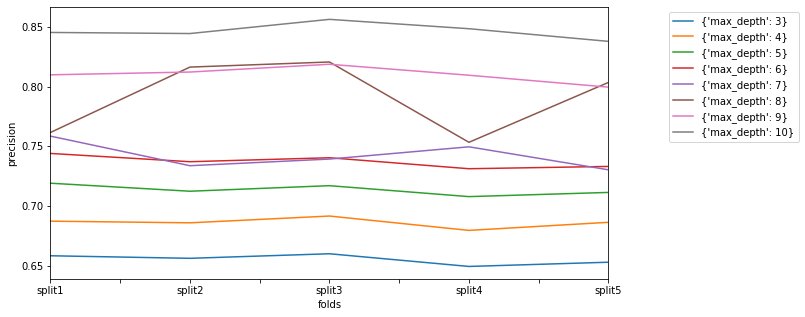

In [15]:
# Plot the grid search scores across each fold
scores.iloc[1:,:].plot(figsize=(10,5)) # plot
plt.legend(labels=scores.iloc[0,:], bbox_to_anchor=(1.1, 1))
    # add legend but add it outside of the plot area
plt.ylabel('precision') # ylabel
plt.xlabel('folds') # xlabel
plt.show() # show the plot

There seems to be a big gap in precision between a max_depth of 4 and 5, but the spacing between lines gets slightly smaller at higher max_depth values. Perhaps, for the sake of this project and what we need it to do, we could select a max depth of 6 and still get a pretty good (72% precision for most folds) idea of whether there is or isn't a shark in the area. This is better than what is currently out there, which is no indiciation of whether there would or wouldn't be a shark there. We can use the data we have now to fit a decision tree to the data and see which variables are most important in the model.

In [16]:
# Set up Decision Tree Classifier
gs = DecisionTreeClassifier(criterion='entropy', max_depth=6)

gs.fit(X_train, y_train) # fit to the data

# Use predict to see how well this model performs on the training and
# testing data and calculate the precision.
y_pred_train = gs.predict(X_train)
y_pred = gs.predict(X_test)
print('Training Precision: ' + str(precision_recall_calc(y_train, y_pred_train)[0]))
print('Testing Precision: ' + str(precision_recall_calc(y_test, y_pred)[0]))

features = pd.DataFrame({'feature':X_train.columns, 'importance':gs.feature_importances_})
    # create data frame of feature importances
features = features[features.importance > 0].sort_values(by='importance',ascending=False)
    # only keep those > 0 and sort by importance
print(features) # print

Training Precision: 0.9277835972641567
Testing Precision: 0.9314328302589902
           feature  importance
0    DepthGradient    0.268638
96       Year_2019    0.256736
42    Zone_1363502    0.100834
23    Zone_1298510    0.063035
33    Zone_1336001    0.061536
68    Zone_1463417    0.060472
20    Zone_1291015    0.053533
29    Zone_1328502    0.037854
1            TempC    0.036566
48    Zone_1385962    0.030204
97  Receiver_D_2.0    0.007804
92       Year_2015    0.005910
44    Zone_1370968    0.005308
14    Zone_1238588    0.005306
91        Month_12    0.004532
3             ChlA    0.001734


Precision for the training and testing data from this relatively simple model is pretty good, with values greater than 0.90.

From this output, it seems like Depth Gradient and the Year 2019 are most important factors in the model, followed by partifular zones, temperature, and a receiver density of 2 receivers per zone. Keeping the years in the model is important for being able to predict shark presence or absence in previous years. Since year 2019 was not over at the time this model started, it makes sense that 2019 would have a large effect on the model. There were less training data and likely fewer sharks detected in this year. Particular zones that may influence the model likely indicate previous 'hotspot' locations, where many sharks were detected in the past, and having two receivers in an area is quite common in the dataset, but also covers a lot more area within the zone than just one receiver, so there's a higher probability that zones with two receivers deployed can pick up more shark detections. 

Let's see what the decision tree looks like so that we can tell our audience more about when to expect sharks (with ~ 70% precision).

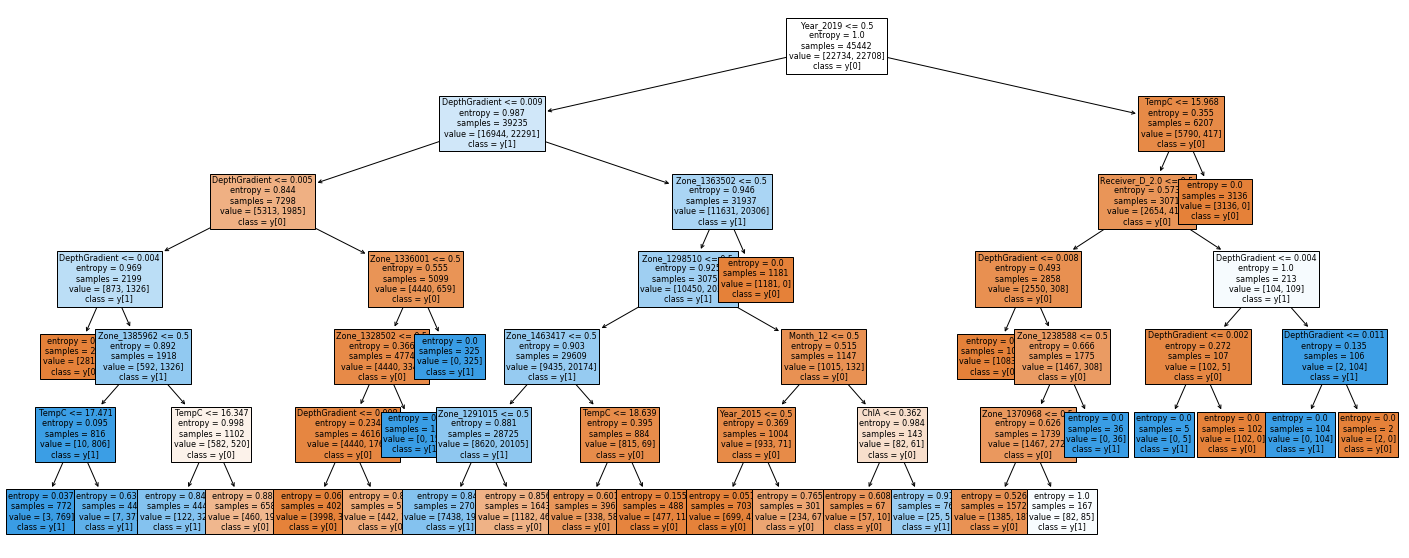

In [17]:
# Plot the decision tree
plt.figure(figsize=(25,10)) # set figure size
tree.plot_tree(gs, filled=True, fontsize=8, class_names=True, feature_names=X_train.columns)  
    # plot the tree 
plt.show() # show plot

If we start at the top, the left side of the decision tree represents decisions that fall on the 'true' end of the suggestion in the box, while the right side represence the 'false' end of the suggestion. For example, at the top, we have Year 2019 <= 0.5. We one-hot encoded year, so if it's 2019, you would have a 1 here and if it's not 2019, you would have a 0. So, the left part of the tree represents times when Year 2019 is less than 0.5 (when it's not 2019) and the right part of the tree represents when it is 2019. When it's 2019, temperatures that exceed 15.968C resulted in no sharks detected, while temperatures that were less than 15.968C were passed to the next part of the tree, which dealt with depth gradient. If we look at things like depth gradient on the left side, it seems that the sharks are choosing areas with flat sand habitats (depth gradient <= 0.004 m). 

##### Grid Search for Gradient Boosting

Decision Trees can be useful for getting a more interpretable reasoning behind classifying a scenario as 'likely a shark is present' or 'likely a shark is not present'. However, sometimes their performance is lacking. So while a Decision Tree might be good to share with people who are interested in thresholds to look out for, gradient boosting might be best to actually run the data and provide a daily estimate of 0 (probably no sharks) or 1 (probably a shark).

In [18]:
# Grid Search for gradient boosting
parameters = {'learning_rate':[0.075, 0.1, 0.25, 0.5, 0.75], 'n_estimators':[10, 50, 100], 
             'max_depth':[3,6,8]}
    # Set parameters
gb = GradientBoostingClassifier()
    # set classifier
clf = GridSearchCV(gb, parameters, cv=5, scoring='precision')
    # run grid search with a fold of 5
clf.fit(X_train, y_train) # fit to the data
print(clf.best_params_) # get the best parameters

{'learning_rate': 0.75, 'max_depth': 8, 'n_estimators': 100}


This output gives us the best model using the parameters we specified, but it doesn't necessarily mean that we need to use this model for the final approach. Perhaps these models don't change that much across these different parameters. We should visualize it to check the spread of precision values for each fold.

In [19]:
# Find the model scores to be able to plot the results
gb_scores = pd.DataFrame({'model':clf.cv_results_['params'], 'split1':clf.cv_results_['split0_test_score'], 
                      'split2':clf.cv_results_['split1_test_score'], 'split3':clf.cv_results_['split2_test_score'], 
                      'split4':clf.cv_results_['split3_test_score'], 'split5':clf.cv_results_['split4_test_score']})
    # get model results
gb_scores = gb_scores.transpose() # transpose the data so it's easier to plot

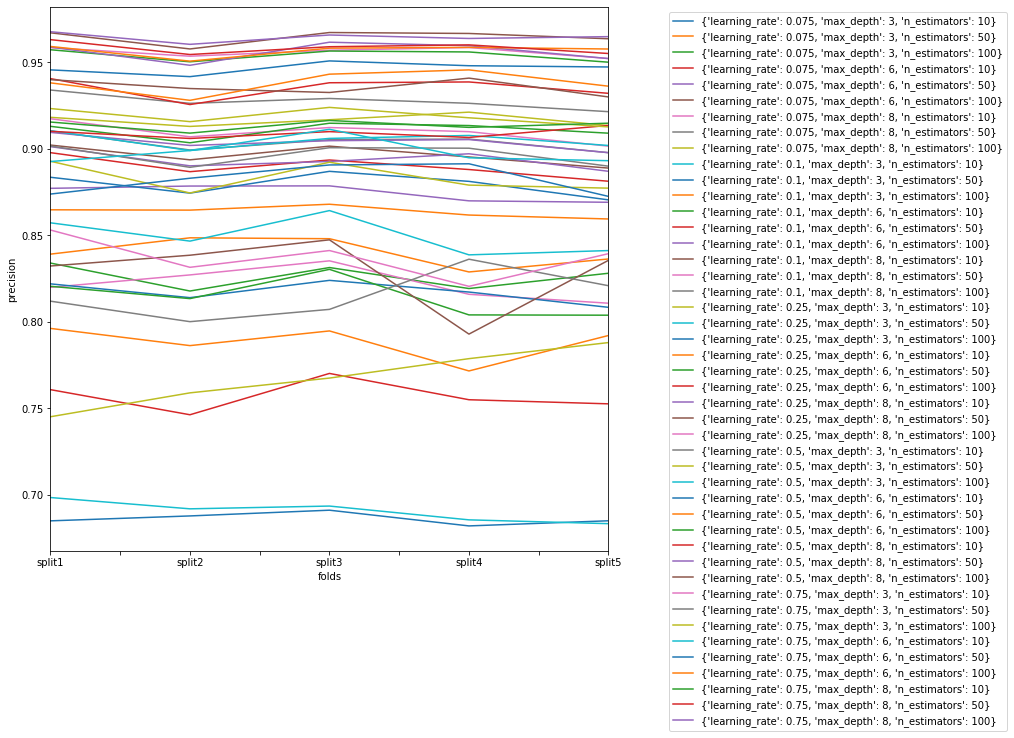

In [20]:
# Plot the grid search scores across each fold
gb_scores.iloc[1:,:].plot(figsize=(10,10))
plt.legend(labels=gb_scores.iloc[0,:], bbox_to_anchor=(1.1, 1))
    # add legend but add it outside of the plot area
plt.ylabel('precision') # ylabel
plt.xlabel('folds') # xlabel
plt.show() # show the plot

In [21]:
gb_scores # show the results because the plot is difficult to interpret

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
model,"{'learning_rate': 0.075, 'max_depth': 3, 'n_es...","{'learning_rate': 0.075, 'max_depth': 3, 'n_es...","{'learning_rate': 0.075, 'max_depth': 3, 'n_es...","{'learning_rate': 0.075, 'max_depth': 6, 'n_es...","{'learning_rate': 0.075, 'max_depth': 6, 'n_es...","{'learning_rate': 0.075, 'max_depth': 6, 'n_es...","{'learning_rate': 0.075, 'max_depth': 8, 'n_es...","{'learning_rate': 0.075, 'max_depth': 8, 'n_es...","{'learning_rate': 0.075, 'max_depth': 8, 'n_es...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",...,"{'learning_rate': 0.5, 'max_depth': 8, 'n_esti...","{'learning_rate': 0.75, 'max_depth': 3, 'n_est...","{'learning_rate': 0.75, 'max_depth': 3, 'n_est...","{'learning_rate': 0.75, 'max_depth': 3, 'n_est...","{'learning_rate': 0.75, 'max_depth': 6, 'n_est...","{'learning_rate': 0.75, 'max_depth': 6, 'n_est...","{'learning_rate': 0.75, 'max_depth': 6, 'n_est...","{'learning_rate': 0.75, 'max_depth': 8, 'n_est...","{'learning_rate': 0.75, 'max_depth': 8, 'n_est...","{'learning_rate': 0.75, 'max_depth': 8, 'n_est..."
split1,0.684949,0.796219,0.834001,0.760808,0.877208,0.902206,0.819955,0.910316,0.918256,0.698434,...,0.967122,0.853101,0.901688,0.923338,0.8927,0.945689,0.959236,0.915528,0.963176,0.967749
split2,0.687792,0.786269,0.817831,0.746291,0.87852,0.893683,0.827141,0.899361,0.912998,0.691901,...,0.957788,0.831539,0.889353,0.915769,0.899054,0.941782,0.950734,0.909129,0.954574,0.960457
split3,0.691109,0.794755,0.831407,0.770184,0.87863,0.901591,0.835278,0.905334,0.91686,0.693498,...,0.967294,0.841237,0.900685,0.924007,0.911338,0.950872,0.958245,0.916454,0.959075,0.965856
split4,0.682023,0.771621,0.81927,0.754977,0.869973,0.895342,0.815939,0.905704,0.921257,0.685524,...,0.966745,0.820543,0.900403,0.917988,0.894858,0.948093,0.958704,0.91245,0.960153,0.963853
split5,0.684989,0.792117,0.828103,0.752604,0.869138,0.888912,0.81078,0.897825,0.913483,0.683323,...,0.963687,0.839435,0.890025,0.912723,0.893184,0.947368,0.957761,0.914867,0.955158,0.964909


Most of the precision values are 0.80 or above. We want to be able to choose the a model that is the simplest, but has pretty decent precision. The simplest model with precision values consistently over 0.80 has a learning rate of 0.075, a max_depth of 3, and n_estimators of 100 (the default).

In [22]:
# Check for the most important parameters for this particular model.
# Build the classifier
gb = GradientBoostingClassifier(learning_rate=0.075, max_depth=3, n_estimators=100)
gb.fit(X_train, y_train) # train the data

# Use predict to see how well this model performs on the training and
# testing data and calculate the precision.
y_pred_train = gb.predict(X_train)
y_pred = gb.predict(X_test)
print('Training Precision: ' + str(precision_recall_calc(y_train, y_pred_train)[0]))
print('Testing Precision: ' + str(precision_recall_calc(y_test, y_pred)[0]))

features = pd.DataFrame({'feature':X_train.columns, 'importance':gb.feature_importances_})
    # create data frame of feature importances
features = features[features.importance > 0].sort_values(by='importance',ascending=False)
    # only keep those > 0 and sort by importance
print(features.reset_index(drop=True)[0:11]) # print

Training Precision: 0.9040602802841237
Testing Precision: 0.9027837876821001
           feature  importance
0    DepthGradient    0.267537
1        Year_2019    0.197763
2     Zone_1363502    0.069079
3        Year_2015    0.046643
4   Receiver_D_2.0    0.038734
5     Zone_1298510    0.038016
6            TempC    0.037991
7     Zone_1463417    0.035802
8        Year_2018    0.032114
9     Zone_1291015    0.023901
10    Zone_1291014    0.020228


The precision for the training and testing data for this simple model is more than 0.90, which is pretty good and better than our grid search predicted from 5 folds. 

I only printed the top ten important features for this model because a lot more features were important for the gradient boosting algorithm. In general, though, it seems like depth gradient and 2019 are still the most important features here. More years are added in, which were probably found to be important from other trees in the forest that was generated that I wasn't able to see in the one decision tree that I originally built. This information can allow us to tell our clients that, for historical data, year is pretty important. This probably adds to a lot of the uncertainty within the model results, because each year comes with its own set of unpredictable environmental changes.

##### What about regions without receivers? 

This model can be useful, but what about regions or locations that might have particular environmental conditions but no receivers that were deployed? We might be able to adapt this model by taking out receiver density. Our modeling power will definitely diminish, but it might be more useful for people deciding where to actually put receivers for finding tagged sharks. 

In [23]:
# Balance the data by randomly sampling with replacement from the 
# smaller dataset
zeros = orig_dat[orig_dat.presence == 0]  # no sharks
ones = orig_dat[orig_dat.presence == 1].sample(len(zeros), 
                                               random_state=33, 
                                               replace=True) 
    # take a random sample of 1s

dat_2 = ones.append(zeros) # re-write data frame

# Only keep these values of the data frame and convert to objects
dat_2 = dat_2[['presence','Zone','DepthGradient', 'TempC', 'Sal', 'ChlA', 
               'MoonPhase', 'Month', 'Year']].copy()
dat_2 = dat_2.astype({'Zone':'object', 'MoonPhase':'object', 'Month':'object', 
                      'Year':'object'})

# Get dummies for the dataset
categories = pd.get_dummies(dat_2.loc[:,['Zone', 'MoonPhase', 'Month', 'Year']],
                            drop_first=True)

# Copy columns back over into the old dataset
dat_2[categories.columns] = categories.copy()

# Drop original columns that we now have dummies for
dat_2 = dat_2.drop(['Zone', 'MoonPhase','Month', 'Year'], axis=1) 

# Split data appropriately
y_2 = dat_2.presence
X_2 = dat_2.drop('presence', axis=1)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.25, random_state=33) 

In [24]:
# Re-run the grid Search for gradient boosting
parameters = {'learning_rate':[0.075, 0.1, 0.25, 0.5, 0.75], 'n_estimators':[10, 50, 100], 
             'max_depth':[3,6,8]}
    # Set parameters
gb = GradientBoostingClassifier()
    # set classifier
clf = GridSearchCV(gb, parameters, cv=5, scoring='precision')
    # run grid search with a fold of 5
clf.fit(X_train, y_train) # fit to the data
print(clf.best_params_) # get the best parameters

{'learning_rate': 0.75, 'max_depth': 8, 'n_estimators': 100}


Again, let's look at how the other models perform to see if there is a simpler model that still gives us decent (0.80+) precision.

In [25]:
# Find the model scores to be able to plot the results
gb_scores = pd.DataFrame({'model':clf.cv_results_['params'], 'split1':clf.cv_results_['split0_test_score'], 
                      'split2':clf.cv_results_['split1_test_score'], 'split3':clf.cv_results_['split2_test_score'], 
                      'split4':clf.cv_results_['split3_test_score'], 'split5':clf.cv_results_['split4_test_score']})
    # get model results
gb_scores = gb_scores.transpose() # transpose the data so it's easier to plot

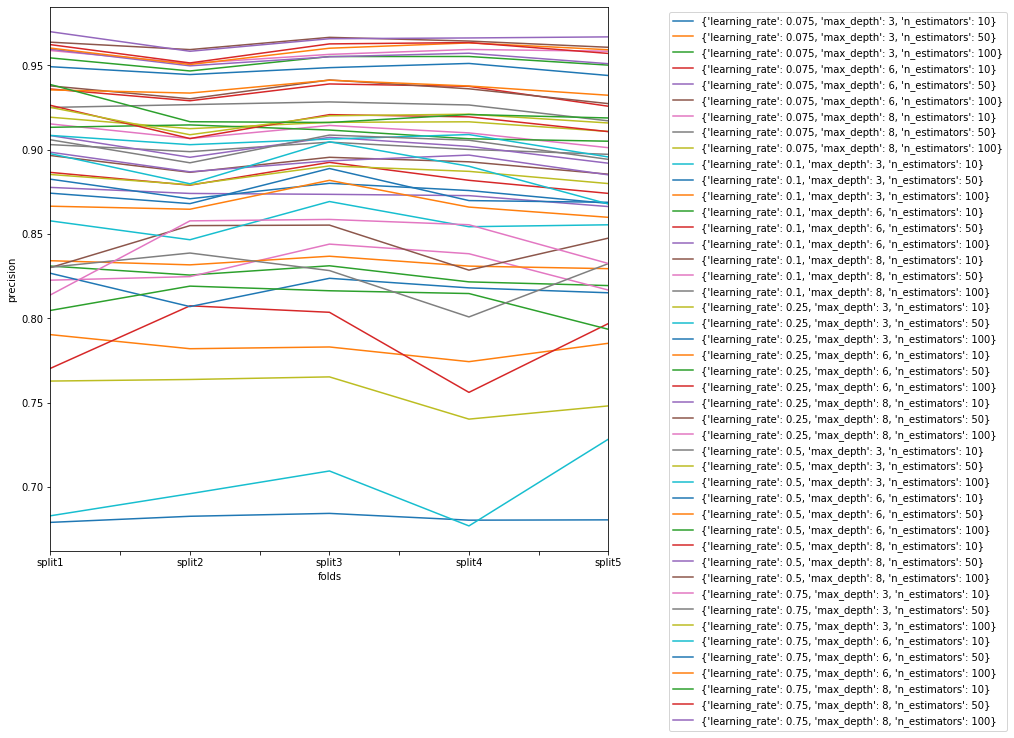

In [26]:
# Re-plot the grid search scores across each fold
gb_scores.iloc[1:,:].plot(figsize=(10,10))
plt.legend(labels=gb_scores.iloc[0,:], bbox_to_anchor=(1.1, 1))
    # add legend but add it outside of the plot area
plt.ylabel('precision') # ylabel
plt.xlabel('folds') # xlabel
plt.show() # show the plot

In [27]:
gb_scores # show the results because the plot is difficult to interpret

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
model,"{'learning_rate': 0.075, 'max_depth': 3, 'n_es...","{'learning_rate': 0.075, 'max_depth': 3, 'n_es...","{'learning_rate': 0.075, 'max_depth': 3, 'n_es...","{'learning_rate': 0.075, 'max_depth': 6, 'n_es...","{'learning_rate': 0.075, 'max_depth': 6, 'n_es...","{'learning_rate': 0.075, 'max_depth': 6, 'n_es...","{'learning_rate': 0.075, 'max_depth': 8, 'n_es...","{'learning_rate': 0.075, 'max_depth': 8, 'n_es...","{'learning_rate': 0.075, 'max_depth': 8, 'n_es...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",...,"{'learning_rate': 0.5, 'max_depth': 8, 'n_esti...","{'learning_rate': 0.75, 'max_depth': 3, 'n_est...","{'learning_rate': 0.75, 'max_depth': 3, 'n_est...","{'learning_rate': 0.75, 'max_depth': 3, 'n_est...","{'learning_rate': 0.75, 'max_depth': 6, 'n_est...","{'learning_rate': 0.75, 'max_depth': 6, 'n_est...","{'learning_rate': 0.75, 'max_depth': 6, 'n_est...","{'learning_rate': 0.75, 'max_depth': 8, 'n_est...","{'learning_rate': 0.75, 'max_depth': 8, 'n_est...","{'learning_rate': 0.75, 'max_depth': 8, 'n_est..."
split1,0.679002,0.790356,0.831025,0.770364,0.877687,0.896588,0.822652,0.903064,0.919314,0.682907,...,0.96383,0.813931,0.905917,0.925155,0.897668,0.949278,0.960314,0.938683,0.962364,0.970021
split2,0.682614,0.782002,0.825686,0.807443,0.874103,0.886638,0.824766,0.898886,0.912531,0.696012,...,0.959425,0.857837,0.892279,0.90892,0.879844,0.944621,0.950576,0.916649,0.951511,0.95843
split3,0.684331,0.78304,0.831192,0.803612,0.873575,0.895544,0.84405,0.904522,0.91628,0.709486,...,0.966688,0.858691,0.908719,0.920172,0.904752,0.948718,0.960238,0.916192,0.962798,0.965878
split4,0.680312,0.77433,0.821647,0.75611,0.872798,0.892865,0.838339,0.900187,0.916597,0.676903,...,0.964491,0.855539,0.905652,0.921103,0.890226,0.951209,0.963389,0.920908,0.963602,0.966326
split5,0.680493,0.78523,0.81945,0.79696,0.866316,0.885504,0.816775,0.897304,0.910877,0.728388,...,0.960788,0.832529,0.894304,0.915896,0.867844,0.944059,0.959339,0.918868,0.957146,0.966965


The model using a learning rate of 0.075, max depth of 3, and number of estimators of 100 actually seems to have performed a little bit better after taking out the receiver density. 

In [28]:
# Create a gradient boosting classifier and fit to the data
gb = GradientBoostingClassifier(learning_rate=0.075, max_depth=3, n_estimators=100)
gb.fit(X_train, y_train) # fit 

# Use predict to see how well this model performs on the training and
# testing data and calculate the precision.
y_pred_train = gb.predict(X_train)
y_pred = gb.predict(X_test)
print('Training Precision: ' + str(precision_recall_calc(y_train, y_pred_train)[0]))
print('Testing Precision: ' + str(precision_recall_calc(y_test, y_pred)[0]))

features = pd.DataFrame({'feature':X_train.columns, 'importance':gb.feature_importances_})
    # create data frame of feature importances
features = features[features.importance > 0].sort_values(by='importance',ascending=False)
    # only keep those > 0 and sort by importance
print(features.reset_index(drop=True)[0:11]) # print

Training Precision: 0.9157216366088824
Testing Precision: 0.9155609167671894
          feature  importance
0   DepthGradient    0.276576
1       Year_2019    0.203176
2    Zone_1363502    0.072678
3       Year_2015    0.050741
4           TempC    0.043467
5    Zone_1463417    0.039882
6    Zone_1298510    0.037361
7       Year_2018    0.034717
8    Zone_1291015    0.022747
9    Zone_1291014    0.019466
10   Zone_1336001    0.016731


The precision for both the training and the testing data is still in the .90s, which is great (and even better than our grid search predicted. In addition, the same parameters (depth gradient, temperatures, specific areas, and years) seem to be important here, which is good. I think this is probably the best bet for testing the data that comes in, to see if we get an indication of shark presence or absence, regardless of if receivers are in the water. This part is probably most useful for lifeguards who need to know whether they should be on high alert while watching their beaches, or not.

### One More Example: K Nearest Neighbors

K Nearest Neighbors may also be a useful tool because it pairs similar values together and assigns the classification based on the point(s) around it. Processing time is sometimes longer for testing datasets, because it has to run through the entire training dataset and calculate the nearest neighbor. But, it might give us even higher precision. We'll use the same non-receiver density dataset, to see if we can get a better precision value than the gradient boosting classifier.

In [29]:
# Grid Search for KNN
parameters = {'n_neighbors': [1,5,10,15], 
              'weights': ('uniform', 'distance')}
    # Set parameters
knn = KNeighborsClassifier()
    # set classifier
clf = GridSearchCV(knn, parameters, cv=5)
    # run grid search with a fold of 5
clf.fit(X_train, y_train) # fit to the data
print(clf.best_params_) # get the best parameters

{'n_neighbors': 1, 'weights': 'uniform'}


In [30]:
# Fit the data with the best model parameters
knn =  KNeighborsClassifier(n_neighbors = 1, weights='uniform')

knn.fit(X_train, y_train) # fit

y_pred_test = knn.predict(X_test) # test

# Describe precision
print('Precision: ' + str(precision_recall_calc(y_test, y_pred_test)[0]))

Precision: 0.9987546699875467


As previously thought, this model seems to perform better on the testing data, because it's just using the classification of the one closest neighbor. This might be useful to help ground truth the results from the gradient boosting classifier. However, with this model, we can't tell people which value is most important - is it depth gradient? Temperature? Something else? We really don't know. So, for the purpose of just getting a precise estimate, KNN might be the best way to go. However, getting a result that we can use to help people plan where they should be spending more time, effort, and money, might be most useful using a decision tree or forest.